### Preprocessing

In [1]:
import librosa
import numpy as np
from skimage.transform import resize
import os
import keras

In [3]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']


model = keras.models.load_model('./BadBoyModelV2.keras')

In [60]:
# audio_files['jazz'] 

#### Prediction

In [61]:
audio = librosa.core.load('./Data/genres_original/country/country.00008.wav')
mel_specs = []
y = audio[0]
sr = audio[1]

spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max)
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
if spect.shape[1] != 600:
    # spect.resize(128,660, refcheck=False)
    spect = spect[:128,:600]
    # print(spect.shape)
    spect.reshape(128,600)

mel_specs.append(spect)
    
X = np.array(mel_specs)

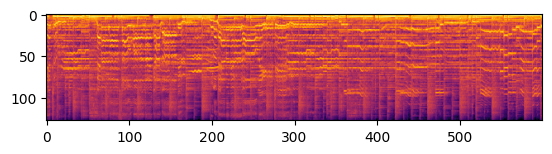

In [62]:
import matplotlib.pyplot as plt

plt.imshow(mel_specs[0], cmap="inferno")

In [63]:
X.shape

(1, 128, 600)

In [64]:
res = model.predict(X)

1/1 [==============================] - 0s 167ms/step


In [65]:
actual_best = 0
result_label = ""


predicted_class_index = np.argmax(res[0])
predicted_class_name = genres[predicted_class_index]
predicted_class_name
# for i in range(len(genres)):
#     actual = res[0][i]
#     if actual > actual_best:
#         actual_best = actual
#         result_label = genres[i]

# print(result_label, str(actual_best))

'pop'

In [66]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

In [67]:
for i in genres:
    if 'blues' not in i:
        print(i)

classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


#### Create img

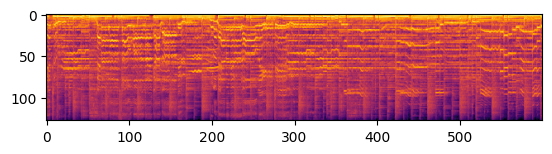

In [68]:
plt.imshow(mel_specs[0], cmap="inferno")

In [69]:
# Code pour créer votre image
plt.imshow(mel_specs[0], cmap="inferno")

# Spécifiez le chemin et le nom de fichier pour l'enregistrement
nom_fichier = "pred.png"

# Enregistrez l'image
# plt.savefig(nom_fichier)

# Assurez-vous de fermer la figure après l'enregistrement (pour éviter d'afficher une seconde fois)
plt.close()

#### Faire plusieurs pred

In [70]:
all_predictions = []

In [73]:
audio_dir = './Data/genres_original/country/'
for filename in os.listdir(audio_dir):
    # Chargez le fichier audio
    audio_path = os.path.join(audio_dir, filename)
    audio = librosa.core.load(audio_path)
    
    mel_specs = []
    y = audio[0]
    sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)

    if spect.shape[1] != 600:
            spect = spect[:128, :600]
        
    mel_specs.append(spect)
    
    X = np.array(mel_specs)
    res = model.predict(X)
    
    predicted_class_index = np.argmax(res[0])
    predicted_class_name = genres[predicted_class_index]
    all_predictions.append((filename, predicted_class_name))

In [72]:
# for i in all_predictions:
#     pred = i[1]
#     name_song = i[0]
#     print(name_song, pred)

#### Réentrainer le model ( fine-tuning )

In [2]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

In [3]:
# Itérer sur les fichiers audio dans le répertoire pour le genre actuel
for g in genres:
  for audio in os.listdir(f'./Data/genres_original/{g}'):
    audio_files[g].append(librosa.core.load(f'./Data/genres_original/{g}/{audio}'))

In [4]:
mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    y = audio[0]
    sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
        
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
    if spect.shape[1] != 600:
      # spect.resize(128,660, refcheck=False)
      spect = spect[:128,:600]
      # print(spect.shape)
      spect.reshape(128,600)

    mel_specs.append(spect)
        
X = np.array(mel_specs)

In [5]:
len(genres)

10

In [6]:
y_cnn = []

for i in range(len(genres)):
  y_cnn +=101*[i] # On a 100 images pour chaque genre
y_cnn = np.array(y_cnn)

In [7]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split # Split de dataset et optimisation des hyperparamètres

# On split ensuite nos données en données de test et données d'entraînements :
y_cnn = to_categorical(y_cnn)
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn)

In [8]:
# On pense à normaliser les données, c'est important pour l'analyse d'images :
x_cnn_train /= -80
x_cnn_test /= -80

In [9]:
# A présent on met en forme nos données pour l'entraînement :
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 600, 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 600, 1)

In [10]:
model = keras.models.load_model('./BadBoyModelV2.keras')

In [11]:
for layer in model.layers[:5]:
    layer.trainable = False

In [12]:
import tensorflow as tf

# Ajoutez des couches personnalisées
model.add(tf.keras.layers.Dense(64, activation='relu', name = 'dense_3'))
model.add(tf.keras.layers.Dense(10, activation='softmax',name = 'dense_4'))


In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(x_cnn_train,
                    y_cnn_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (x_cnn_test,y_cnn_test))

Epoch 1/10
12/12 [==============================] - 25s 2s/step - loss: 2.2786 - accuracy: 0.1136 - val_loss: 2.2801 - val_accuracy: 0.1462
Epoch 2/10
12/12 [==============================] - 21s 2s/step - loss: 2.2738 - accuracy: 0.1400 - val_loss: 2.2781 - val_accuracy: 0.1581
Epoch 3/10
12/12 [==============================] - 19s 2s/step - loss: 2.2715 - accuracy: 0.1625 - val_loss: 2.2772 - val_accuracy: 0.1502
Epoch 4/10
12/12 [==============================] - 19s 2s/step - loss: 2.2699 - accuracy: 0.1823 - val_loss: 2.2760 - val_accuracy: 0.1581
Epoch 5/10
12/12 [==============================] - 21s 2s/step - loss: 2.2679 - accuracy: 0.2048 - val_loss: 2.2741 - val_accuracy: 0.1621
Epoch 6/10
12/12 [==============================] - 20s 2s/step - loss: 2.2660 - accuracy: 0.2206 - val_loss: 2.2725 - val_accuracy: 0.1462
Epoch 7/10
12/12 [==============================] - 21s 2s/step - loss: 2.2640 - accuracy: 0.2127 - val_loss: 2.2713 - val_accuracy: 0.1383
Epoch 8/10
12/12 [==

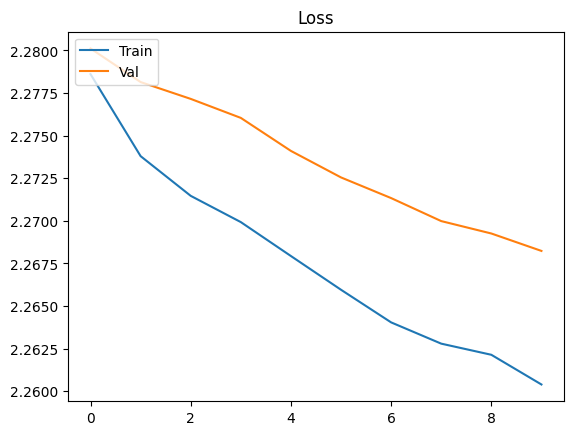

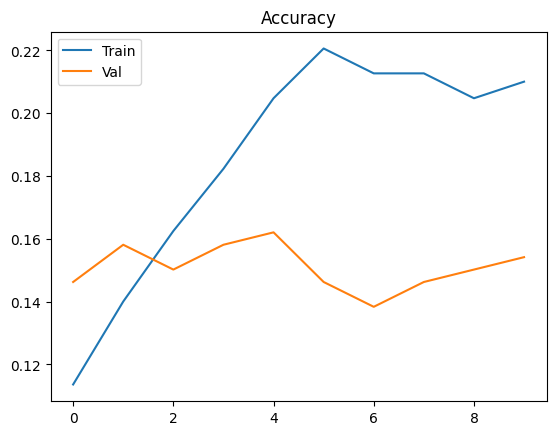

In [15]:
import matplotlib.pyplot as plt

loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

8/8 [==============================] - 3s 367ms/step


Text(110.44999999999997, 0.5, 'predicted label')

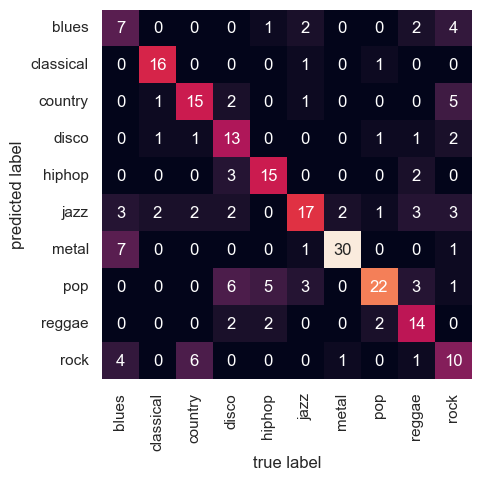

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix # Métriques pour la mesure de performances
sns.set()
predictions = model.predict(x_cnn_test)
mat = confusion_matrix(np.argmax(y_cnn_test, 1), np.argmax(predictions, 1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [104]:
audio = librosa.core.load('./Data/genres_original/reggae/reggae.00008.wav')
mel_specs = []
y = audio[0]
sr = audio[1]

spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max)
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
if spect.shape[1] != 600:
    # spect.resize(128,660, refcheck=False)
    spect = spect[:128,:600]
    # print(spect.shape)
    spect.reshape(128,600)

mel_specs.append(spect)
    
X = np.array(mel_specs)

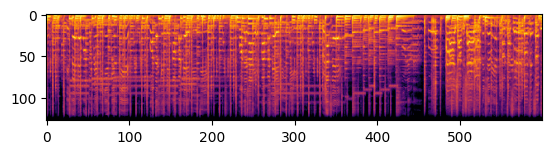

In [105]:
import matplotlib.pyplot as plt

plt.imshow(mel_specs[0], cmap="inferno")

In [106]:
# model.summary()

In [107]:
# X = np.expand_dims(X, axis=0)

In [108]:
X.shape

(1, 128, 600)

In [109]:
res = model.predict(X)

1/1 [==============================] - 0s 63ms/step


In [110]:
actual_best = 0
result_label = ""


# predicted_class_index = np.argmax(res[0])
# predicted_class_name = genres[predicted_class_index]
# predicted_class_name
for i in range(len(genres)):
    actual = res[0][i]
    print(actual)
    if actual > actual_best:
        actual_best = actual
        result_label = genres[i]

print(result_label, str(actual_best))

0.081690766
0.13672055
0.13303356
0.09698203
0.09371758
0.06817758
0.10975099
0.09540785
0.08740293
0.09711614
classical 0.13672055


In [111]:
my_modelV2 = keras.models.load_model('./BadBoyModelV2.keras')

In [112]:
res2 = my_modelV2.predict(X)

1/1 [==============================] - 0s 172ms/step


In [113]:
actual_best = 0
result_label = ""


# predicted_class_index = np.argmax(res2[0])
# predicted_class_name = genres[predicted_class_index]
# predicted_class_name
for i in range(len(genres)):
    actual = res2[0][i]
    print(actual)
    if actual > actual_best:
        actual_best = actual
        result_label = genres[i]

print(result_label, str(actual_best))

0.0
1.251733e-08
0.0
0.0
0.0
5.0221777e-10
0.0
1.0
0.0
8.325743e-34
pop 1.0


In [114]:
# model.save('BadBoyModelV2.1.keras')